In [320]:
!pip install forex-python

In [339]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import requests
import json
import time
import joblib
import datetime

from sklearn import preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import GridSearchCV
from sklearn import tree
from sklearn.preprocessing import StandardScaler

from forex_python.converter import CurrencyRates

###RandomizedSearchCV

from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score

In [351]:
def change_currency(val, curr_from, curr_to):
  if curr_from != curr_to:
    curr_from = curr_from.upper()
    curr_to = curr_to.upper()
    c = CurrencyRates()
    return round(val/c.get_rate(curr_to, curr_from, datetime.datetime.now()))

In [333]:
def remove_mark(value):
    marks = ['>', '<', '-', '+', '_', ' ', '  ', ',']
    for mark in marks:
        if pd.notna(value) and mark in value:
            return value.replace(mark, '')
    return value

In [334]:
def remove_blanc(value):
    if value == '':
        value = 0
        return value

In [122]:
def evaluate_regression_model(model, X_test, y_test):
    """
    Evaluates the performance of a regression model and provides a summary.

    Parameters:
        model: A trained regression model from scikit-learn.
        X_test: Test features.
        y_test: Test labels.
    """
    # Predictions on the test set
    y_pred = model.predict(X_test)

    # Calculate metrics
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)  # RMSE
    r2 = r2_score(y_test, y_pred)

    # Display results
    print("Regression Model Evaluation:")
    print("===========================")
    print(f"Mean Absolute Error (MAE): {mae:.2f}")
    print(f"Mean Squared Error (MSE): {mse:.2f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
    print(f"R-squared (R2): {r2:.2f}")

In [123]:
def api_to_df(url):
    response = requests.get(url)
    content = response.json()
    return pd.DataFrame.from_records(content)


In [124]:
def to_csv_date(df, filename):
    current_date = pd.Timestamp("today").strftime("%m%d%Y")
    df.to_csv(filename + '_' + current_date + '_.csv', index = False)


In [125]:
def remove_null_col(df):
    return df.dropna(axis=1, how='all', inplace = False)

In [126]:
def flatten_list_col(df):
    new_df = pd.DataFrame()
    nested_columns_list = []
    for i, col in enumerate(df.columns):
        if any(isinstance(item, list) for item in df[col]):
            nested_columns_list.append(col)
            new_df= pd.concat([new_df, df[col].apply(pd.Series)], axis = 1)
    new_columns = list(range(len(new_df.columns)))
    new_df.columns = new_columns
    return new_df

In [127]:
def flatten_dict_col(df):
    new_df = pd.DataFrame()
    nested_columns_list = []
    for i, col in enumerate(df.columns):
        if any(isinstance(item, dict) for item in df[col]):
            nested_columns_list.append(col)
            new_df= pd.concat([new_df, df[col].apply(pd.Series)], axis = 1)
#     new_columns = list(range(len(new_df.columns)))
#     new_df.columns = new_columns
    new_df = remove_null_col(new_df)
    return new_df

In [128]:
def unpack_nested_col(nested_col, key_name):
    unpacked_col = {}
    nested_col_unpacked = nested_col.apply(pd.Series)
    for i, col in enumerate(nested_col_unpacked.columns):
        unpacked_col[f'{key_name}_{i}'] = nested_col_unpacked[col].apply(pd.Series)
        if 0 in unpacked_col[f'{key_name}_{i}'].columns:
            if unpacked_col[f'{key_name}_{i}'][0].isna().all():
                unpacked_col[f'{key_name}_{i}'].drop(columns = 0, inplace = True)
    return unpacked_col

In [201]:
def standardize_text(df, text_field):
    df[text_field] = df[text_field].str.lower()
    return df

In [129]:
# new_df, nested_columns_list = flatten_list_col(df.drop(columns='multilocation'))
# display(new_df)
# display(nested_columns_list)

# new_df_1 = flatten_dict_col(new_df)
# new_df_1

# def unpack_nested_col(nested_col, key_name):
#     unpacked_col = {}
#     nested_col_unpacked = nested_col.apply(pd.Series)
#     for i, col in enumerate(nested_col_unpacked.columns):
#         unpacked_col[f'{key_name}_{i}'] = nested_col_unpacked[col].apply(pd.Series)
#         if 0 in unpacked_col[f'{key_name}_{i}'].columns:
#             if unpacked_col[f'{key_name}_{i}'][0].isna().all():
#                 unpacked_col[f'{key_name}_{i}'].drop(columns = 0, inplace = True)

#     keys_to_remove = []
#     unpacked_col_len = len(unpacked_col)
#     for key in unpacked_col:
#         for i, col in enumerate(unpacked_col[key].columns):
#             if any(isinstance(item, dict) for item in unpacked_col[key][col]):
#                 unpacked_col[f'{key_name}_{unpacked_col_len + i}'] = unpacked_col[key][col].apply(pd.Series)
# #                 if 0 in unpacked_col[f'{key_name}_{unpacked_col_len + i}'].columns:
# #                     if unpacked_col[f'{key_name}_{unpacked_col_len + i}'][0].isna().all():
# #                         unpacked_col[f'{key_name}_{unpacked_col_len + i}'].drop(columns = 0, inplace = True)
#                 keys_to_remove.append(key)

#     for key in keys_to_remove:
#         unpacked_col.pop(key)

#     return unpacked_col



In [130]:
def replace_cols(recipient_df, col_replaced, donor_df, col_replacing):
    recipient_df.drop(columns = col_replaced, inplace = True)
    recipient_df = pd.concat([recipient_df, donor_df[col_replacing]])
    return recipient_df

## Reading initial data from API. In this step, we accept all offers from the API, but only receive general information. In order to complete the data, we also read each offer separately using its individual API.


## Unpacking the data


In [131]:
df = api_to_df('https://justjoin.it/api/offers')

df.info()

#to_csv_date(df, 'raw_data')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13299 entries, 0 to 13298
Data columns (total 24 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   title                    13299 non-null  object
 1   street                   13297 non-null  object
 2   city                     13299 non-null  object
 3   country_code             13290 non-null  object
 4   address_text             13299 non-null  object
 5   marker_icon              13299 non-null  object
 6   workplace_type           13299 non-null  object
 7   company_name             13299 non-null  object
 8   company_url              13299 non-null  object
 9   company_size             13299 non-null  object
 10  experience_level         13299 non-null  object
 11  latitude                 13299 non-null  object
 12  longitude                13299 non-null  object
 13  published_at             13299 non-null  object
 14  remote_interview         13299 non-nul

## Select the subset of the data - only "data" marker icon

In [140]:
# Limit observations to those that have flag 'data'
df = df[df['marker_icon'] == 'data']
df.reset_index(drop=True, inplace = True)

## Reading detailed data for every separete offer from API

In [141]:
json_data = []

In [142]:
offers = list(df.id)

In [143]:
len(offers)

1044

In [144]:
for offer in offers:
  url = f'https://justjoin.it/api/offers/{offer}'
  response = requests.get(url)
  json_obj = response.json()
#   initial_df = pd.json_normalize(json_obj)
  json_data.append(json_obj)
#   time.sleep(0.5)

In [145]:
df = pd.DataFrame(json_data)

In [146]:
df.sample(10)

,apply_body,title,street,city,country_code,address_text,marker_icon,workplace_type,company_name,company_url,...,id,tags,body,company_logo_url,banner_url,skills,remote,employment_types,multilocation,company_profile
921,None,Head of AI,Centrum,Kielce,PL,"Centrum, Kielce",data,remote,XTB,https://www.xtb.com/pl,...,xtb-head-of-ai-d68fb7a8-1a35-4b02-99ec-05ede28...,[],<div>Szukamy dynamicznego lidera do kierowania...,https://bucket.justjoin.it/offers/company_logo...,None,"[{'name': 'AI', 'level': 5}, {'name': 'Machine...",True,"[{'type': 'b2b', 'salary': {'from': 30000, 'to...",[{'slug': 'xtb-head-of-ai-ec1c4560-9662-4d9c-a...,"{'url': '/brands/story/xtb-dom-maklerski', 'sh..."
791,None,Data Engineer,Centrum,Kraków,PL,"Centrum, Kraków",data,partly_remote,Unit8,http://www.unit8.co,...,unit8-data-engineer-4ae8668b-b3d1-493b-875e-92...,[],"<div>Founded in 2017, Unit8 is a fast-growing ...",https://bucket.justjoin.it/offers/company_logo...,None,"[{'name': 'Software Development', 'level': 4},...",False,"[{'type': 'b2b', 'salary': {'from': 22000, 'to...",[{'slug': 'unit8-data-engineer-cb284b4d-6c0b-4...,NaN
580,None,Power BI Developer,Centrum,Szczecin,PL,"Centrum, Szczecin",data,remote,hubQuest,https://hubquest.pl/,...,hubquest-power-bi-developer-szczecin,[],<div>\n<strong>We are a team of nerds dedicate...,https://bucket.justjoin.it/offers/company_logo...,None,"[{'name': 'Power BI', 'level': 3}, {'name': 'S...",True,"[{'type': 'b2b', 'salary': {'from': 16000, 'to...",[{'slug': 'hubquest-power-bi-developer-poznan'...,NaN
363,None,Mid Azure Data Engineer,-,Budapeszt,HU,"-, Budapeszt",data,remote,ADASTRA,https://adastra.digital/en/,...,adastra-mid-azure-data-engineer-2b7cd560-5d1d-...,[],<div><strong>We are Adastra Digital</strong></...,https://bucket.justjoin.it/offers/company_logo...,None,"[{'name': 'Azure Data Lake', 'level': 4}, {'na...",True,"[{'type': 'b2b', 'salary': {'from': 3695, 'to'...",[{'slug': 'adastra-mid-azure-data-engineer-396...,"{'url': '/brands/story/adastra', 'short_descri..."
491,None,Data Engineer,centrum,Toruń,PL,"centrum, Toruń",data,remote,Inter Cars S.A.,http://www.intercars.eu,...,inter-cars-s-a-data-engineer-torun,[],<div>\n<strong>Inter Cars Capital Group </stro...,https://bucket.justjoin.it/offers/company_logo...,None,"[{'name': 'Data Science', 'level': 4}, {'name'...",True,"[{'type': 'b2b', 'salary': {'from': 19000, 'to...","[{'slug': 'inter-cars-s-a-data-engineer', 'cit...",NaN
768,None,Data Platform Engineer with German,-,Toruń,PL,"-, Toruń",data,remote,Qurate Retail Group,http://QurateRetailGroup.com,...,qurate-retail-group-data-platform-engineer-wit...,[],<div>\n<strong>The Qurate Retail Group (QRG) <...,https://bucket.justjoin.it/offers/company_logo...,None,"[{'name': 'Oracle', 'level': 4}, {'name': 'SQL...",True,"[{'type': 'permanent', 'salary': {'from': 1800...",[{'slug': 'qurate-retail-group-data-platform-e...,{'url': '/brands/story/qurate-retail-group-glo...
353,None,Big Data Engineer - Data & AI,Wierzbięcice 1B,Poznań,PL,"Wierzbięcice 1B, Poznań",data,partly_remote,Allegro,https://allegro.tech/,...,allegro-big-data-engineer-data-ai-02640a8f-a23...,[],<div>\n<strong>The salary range for this posit...,https://bucket.justjoin.it/offers/company_logo...,None,"[{'name': 'English', 'level': 4}, {'name': 'Ja...",False,"[{'type': 'permanent', 'salary': {'from': 1230...",[{'slug': 'allegro-big-data-engineer-data-ai-b...,"{'url': '/brands/story/allegro', 'short_descri..."
25,None,Senior Data Engineer -Commodity Insights,Marynarki Polskiej 163,Gdańsk,PL,"Marynarki Polskiej 163, Gdańsk",data,remote,S&P Global,https://www.spglobal.com/,...,s-p-global-senior-data-engineer-commodity-insi...,[],<div><strong>Commodity Insights</strong></div>...,https://bucket.justjoin.it/offers/company_logo...,None,"[{'name': 'Python', 'level': 4}, {'name': 'Spa...",True,"[{'type': 'b2b', 'salary': {'from': 17750, 'to...",[{'slug': 's-p-global-senior-data-engineer-com...,NaN
256,None,Programista Hurtowni Danych/BI,Rondo Ignacego Das

In [147]:
len(df)

1044

In [284]:
df.columns

Index(['apply_body', 'title', 'street', 'city', 'country_code', 'address_text',
       'marker_icon', 'workplace_type', 'company_name', 'company_url',
       'company_size', 'experience_level', 'latitude', 'longitude',
       'apply_url', 'published_at', 'remote_interview', 'video_key',
       'video_provider', 'open_to_hire_ukrainians', 'future_consent_title',
       'future_consent', 'information_clause', 'custom_consent_title',
       'custom_consent', 'id', 'tags', 'body', 'company_logo_url',
       'banner_url', 'skills', 'remote', 'employment_types', 'multilocation',
       'company_profile'],
      dtype='object')

### Dealing with skills

In [161]:
print(df['skills'][0])

[{'name': 'Problem Solving', 'level': 4}, {'name': 'JIRA', 'level': 4}, {'name': 'JavaScript', 'level': 3}, {'name': 'SQL', 'level': 3}, {'name': 'Google BigQuery', 'level': 3}, {'name': 'fiddler', 'level': 3}]


In [170]:
old_data = df.to_dict(orient='records')
new_data = []

for index, skills_list in enumerate(df['skills']):
    for skill in skills_list:
        new_row = old_data[index].copy()
        new_row['skill_name'] = skill['name']
        new_row['skill_level'] = skill['level']
        new_data.append(new_row)

In [232]:
new_df = pd.DataFrame(new_data)

In [233]:
new_df.head()

,apply_body,title,street,city,country_code,address_text,marker_icon,workplace_type,company_name,company_url,...,body,company_logo_url,banner_url,skills,remote,employment_types,multilocation,company_profile,skill_name,skill_level
0,None,Data Privacy Manager – Cookies,Kapelanka 42a,Kraków,PL,"Kapelanka 42a, Kraków",data,partly_remote,HSBC Service Delivery,http://www.hsbc.pl,...,<div>\n<strong>Some careers shine brighter tha...,https://bucket.justjoin.it/offers/company_logo...,None,"[{'name': 'Problem Solving', 'level': 4}, {'na...",False,"[{'type': 'permanent', 'salary': {'from': 1600...",[{'slug': 'hsbc-service-delivery-data-privacy-...,NaN,Problem Solving,4
1,None,Data Privacy Manager – Cookies,Kapelanka 42a,Kraków,PL,"Kapelanka 42a, Kraków",data,partly_remote,HSBC Service Delivery,http://www.hsbc.pl,...,<div>\n<strong>Some careers shine brighter tha...,https://bucket.justjoin.it/offers/company_logo...,None,"[{'name': 'Problem Solving', 'level': 4}, {'na...",False,"[{'type': 'permanent', 'salary': {'from': 1600...",[{'slug': 'hsbc-service-delivery-data-privacy-...,NaN,JIRA,4
2,None,Data Privacy Manager – Cookies,Kapelanka 42a,Kraków,PL,"Kapelanka 42a, Kraków",data,partly_remote,HSBC Service Delivery,http://www.hsbc.pl,...,<div>\n<strong>Some careers shine brighter tha...,https://bucket.justjoin.it/offers/company_logo...,None,"[{'name': 'Problem Solving', 'level': 4}, {'na...",False,"[{'type': 'permanent', 'salary': {'from': 1600...",[{'slug': 'hsbc-service-delivery-data-privacy-...,NaN,JavaScript,3
3,None,Data Privacy Manager – Cookies,Kapelanka 42a,Kraków,PL,"Kapelanka 42a, Kraków",data,partly_remote,HSBC Service Delivery,http://www.hsbc.pl,...,<div>\n<strong>Some careers shine brighter tha...,https://bucket.justjoin.it/offers/company_logo...,None,"[{'name': 'Problem Solving', 'level': 4}, {'na...",False,"[{'type': 'permanent', 'salary': {'from': 1600...",[{'slug': 'hsbc-service-delivery-data-privacy-...,NaN,SQL,3
4,None,Data Privacy Manager – Cookies,Kapelanka 42a,Kraków,PL,"Kapelanka 42a, Kraków",data,partly_remote,HSBC Service Delivery,http://www.hsbc.pl,...,<div>\n<strong>Some careers shine brighter tha...,https://bucket.justjoin.it/offers/company_logo...,None,"[{'name': 'Problem Solving', 'level': 4}, {'na...",False,"[{'type': 'permanent', 'salary': {'from': 1600...",[{'slug': 'hsbc-service-delivery-data-privacy-...,NaN,Google BigQuery,3


In [234]:
new_df.skill_name.unique()

array(['Problem Solving', 'JIRA', 'JavaScript', 'SQL', 'Google BigQuery',
       'fiddler', 'Data', 'Machine Learning', 'AWS', 'Confluence',
       'Python', 'R', 'Deep Learning', 'AI', 'DevOps', 'Big Data',
       'Business Intelligence', 'Data Warehouses', 'Data Engineering',
       'Data Science', 'Cloud', 'Linux', 'MLflow', 'Docker', 'Git',
       'PySpark', 'Kubernetes', 'DWH', 'ETL', 'NoSQL', 'Snowflake',
       'AWS (Strong)', 'Java\\Python (Strong)', 'SQL\\NoSQL DB',
       'Map/Reduce', 'Power BI', 'English', 'Data Management',
       'Pricing Models', 'Derivatives', 'Financial Instrumetns',
       'PostgreSQL', 'Flask', 'Cryptocurrencies', 'DAX', 'T-SQL',
       'Tableau', 'Azure', 'Data cloud', 'Data Warehousing',
       'Data engineer', 'Google Cloud Platform', 'Spark', 'Java/Scala',
       'Azure Data Factory', 'Microsoft Power BI', 'Azure SQL',
       'Azure Synapse Analytics', 'Azure Data Storage',
       'Azure Databricks', 'Microsoft Purview', 'Azure Cosmos DB',
      

In [235]:
new_df.skill_name.nunique()

495

In [236]:
clean_df = new_df.copy()
clean_df = standardize_text(clean_df, "title")
clean_df = standardize_text(clean_df, "skill_name")


In [248]:
clean_df.head(5)

,apply_body,title,street,city,country_code,address_text,marker_icon,workplace_type,company_name,company_url,...,body,company_logo_url,banner_url,skills,remote,employment_types,multilocation,company_profile,skill_name,skill_level
0,None,data privacy manager – cookies,Kapelanka 42a,Kraków,PL,"Kapelanka 42a, Kraków",data,partly_remote,HSBC Service Delivery,http://www.hsbc.pl,...,<div>\n<strong>Some careers shine brighter tha...,https://bucket.justjoin.it/offers/company_logo...,None,"[{'name': 'Problem Solving', 'level': 4}, {'na...",False,"[{'type': 'permanent', 'salary': {'from': 1600...",[{'slug': 'hsbc-service-delivery-data-privacy-...,NaN,problem solving,4
1,None,data privacy manager – cookies,Kapelanka 42a,Kraków,PL,"Kapelanka 42a, Kraków",data,partly_remote,HSBC Service Delivery,http://www.hsbc.pl,...,<div>\n<strong>Some careers shine brighter tha...,https://bucket.justjoin.it/offers/company_logo...,None,"[{'name': 'Problem Solving', 'level': 4}, {'na...",False,"[{'type': 'permanent', 'salary': {'from': 1600...",[{'slug': 'hsbc-service-delivery-data-privacy-...,NaN,jira,4
2,None,data privacy manager – cookies,Kapelanka 42a,Kraków,PL,"Kapelanka 42a, Kraków",data,partly_remote,HSBC Service Delivery,http://www.hsbc.pl,...,<div>\n<strong>Some careers shine brighter tha...,https://bucket.justjoin.it/offers/company_logo...,None,"[{'name': 'Problem Solving', 'level': 4}, {'na...",False,"[{'type': 'permanent', 'salary': {'from': 1600...",[{'slug': 'hsbc-service-delivery-data-privacy-...,NaN,javascript,3
3,None,data privacy manager – cookies,Kapelanka 42a,Kraków,PL,"Kapelanka 42a, Kraków",data,partly_remote,HSBC Service Delivery,http://www.hsbc.pl,...,<div>\n<strong>Some careers shine brighter tha...,https://bucket.justjoin.it/offers/company_logo...,None,"[{'name': 'Problem Solving', 'level': 4}, {'na...",False,"[{'type': 'permanent', 'salary': {'from': 1600...",[{'slug': 'hsbc-service-delivery-data-privacy-...,NaN,sql,3
4,None,data privacy manager – cookies,Kapelanka 42a,Kraków,PL,"Kapelanka 42a, Kraków",data,partly_remote,HSBC Service Delivery,http://www.hsbc.pl,...,<div>\n<strong>Some careers shine brighter tha...,https://bucket.justjoin.it/offers/company_logo...,None,"[{'name': 'Problem Solving', 'level': 4}, {'na...",False,"[{'type': 'permanent', 'salary': {'from': 1600...",[{'slug': 'hsbc-service-delivery-data-privacy-...,NaN,google bigquery,3


In [242]:
top_values = clean_df['skill_name'].value_counts().head(30)
top_30_skills = list(top_values.index)

In [244]:
print(top_30_skills)

['sql', 'python', 'power bi', 'english', 'etl', 'aws', 'spark', 'snowflake', 'java', 'big data', 'databases', 'azure', 'scala', 'oracle', 'tableau', 'databricks', 'machine learning', 'data', 'airflow', 'docker', 'pl/sql', 'data science', 'google analytics', 'ssis', 'postgresql', 'kubernetes', 'devops', 'kafka', 'etl tools', 'ci/cd']


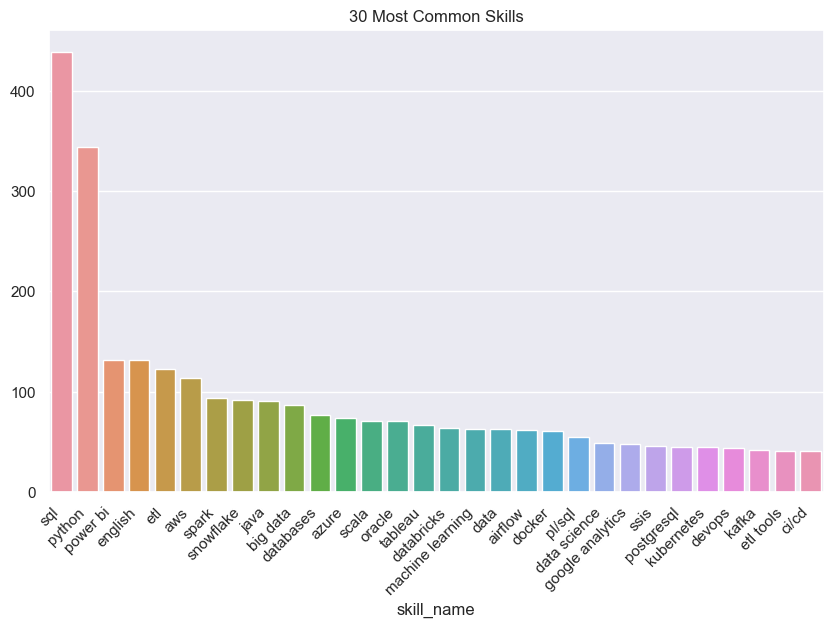

In [253]:
plt.figure(figsize=(10, 6))
sns.set(style="darkgrid")
plot = sns.barplot(x=clean_df['skill_name'].value_counts().iloc[:30].index, y=clean_df['skill_name'].value_counts().iloc[:30].values)
plot.set_title('30 Most Common Skills')
plot.set_xticklabels(plot.get_xticklabels(), rotation=45, horizontalalignment='right')

plt.show()

In [257]:
# Sprawdzanie i zamiana wartości
common_skills_df = clean_df.copy()
mask = ~common_skills_df['skill_name'].isin(top_30_skills)
common_skills_df.loc[mask, 'skill_name'] = None

In [258]:
common_skills_df.head(10)

,apply_body,title,street,city,country_code,address_text,marker_icon,workplace_type,company_name,company_url,...,body,company_logo_url,banner_url,skills,remote,employment_types,multilocation,company_profile,skill_name,skill_level
0,None,data privacy manager – cookies,Kapelanka 42a,Kraków,PL,"Kapelanka 42a, Kraków",data,partly_remote,HSBC Service Delivery,http://www.hsbc.pl,...,<div>\n<strong>Some careers shine brighter tha...,https://bucket.justjoin.it/offers/company_logo...,None,"[{'name': 'Problem Solving', 'level': 4}, {'na...",False,"[{'type': 'permanent', 'salary': {'from': 1600...",[{'slug': 'hsbc-service-delivery-data-privacy-...,NaN,None,4
1,None,data privacy manager – cookies,Kapelanka 42a,Kraków,PL,"Kapelanka 42a, Kraków",data,partly_remote,HSBC Service Delivery,http://www.hsbc.pl,...,<div>\n<strong>Some careers shine brighter tha...,https://bucket.justjoin.it/offers/company_logo...,None,"[{'name': 'Problem Solving', 'level': 4}, {'na...",False,"[{'type': 'permanent', 'salary': {'from': 1600...",[{'slug': 'hsbc-service-delivery-data-privacy-...,NaN,None,4
2,None,data privacy manager – cookies,Kapelanka 42a,Kraków,PL,"Kapelanka 42a, Kraków",data,partly_remote,HSBC Service Delivery,http://www.hsbc.pl,...,<div>\n<strong>Some careers shine brighter tha...,https://bucket.justjoin.it/offers/company_logo...,None,"[{'name': 'Problem Solving', 'level': 4}, {'na...",False,"[{'type': 'permanent', 'salary': {'from': 1600...",[{'slug': 'hsbc-service-delivery-data-privacy-...,NaN,None,3
3,None,data privacy manager – cookies,Kapelanka 42a,Kraków,PL,"Kapelanka 42a, Kraków",data,partly_remote,HSBC Service Delivery,http://www.hsbc.pl,...,<div>\n<strong>Some careers shine brighter tha...,https://bucket.justjoin.it/offers/company_logo...,None,"[{'name': 'Problem Solving', 'level': 4}, {'na...",False,"[{'type': 'permanent', 'salary': {'from': 1600...",[{'slug': 'hsbc-service-delivery-data-privacy-...,NaN,sql,3
4,None,data privacy manager – cookies,Kapelanka 42a,Kraków,PL,"Kapelanka 42a, Kraków",data,partly_remote,HSBC Service Delivery,http://www.hsbc.pl,...,<div>\n<strong>Some careers shine brighter tha...,https://bucket.justjoin.it/offers/company_logo...,None,"[{'name': 'Problem Solving', 'level': 4}, {'na...",False,"[{'type': 'permanent', 'salary': {'from': 1600...",[{'slug': 'hsbc-service-delivery-data-privacy-...,NaN,None,3
5,None,data privacy manager – cookies,Kapelanka 42a,Kraków,PL,"Kapelanka 42a, Kraków",data,partly_remote,HSBC Service Delivery,http://www.hsbc.pl,...,<div>\n<strong>Some careers shine brighter tha...,https://bucket.justjoin.it/offers/company_logo...,None,"[{'name': 'Problem Solving', 'level': 4}, {'na...",False,"[{'type': 'permanent', 'salary': {'from': 1600...",[{'slug': 'hsbc-service-delivery-data-privacy-...,NaN,None,3
6,None,data scientist,Plac Europejski 1,Warszawa,PL,"Plac Europejski 1, Warszawa",data,partly_remote,HL Tech,http://www.hltech.com,...,<div>HL Tech is a modern technology centre sup...,https://bucket.justjoin.it/offers/company_logo...,None,"[{'name': 'Data', 'level': 4}, {'name': 'Machi...",False,"[{'type': 'permanent', 'salary': {'from': 1800...",[{'slug': 'hl-tech-data-scientist-skierniewice...,"{'url': '/brands/story/hl-tech', 'short_descri...",data,4
7,None,data scientist,Plac Europejski 1,Warszawa,PL,"Plac Europejski 1, Warszawa",data,partly_remote,HL Tech,http://www.hltech.com,...,<div>HL Tech is a modern technology centre sup...,https://bucket.justjoin.it/offers/company_logo...,None,"[{'name': 'Data', 'level': 4}, {'name': 'Machi...",False,"[{'type': 'permanent', 'salary': {'from': 1800...",[{'slug': 'hl-tech-data-scientist-skierniewice...,"{'url': '/brands/story/hl-tech', 'short_descri...",machine learning,4
8,None,data scientist,Plac Europejski 1,Warszawa,PL,"Plac Europejski 1, Warszawa",data,partly_remote,HL Tech,http://www.hltech.com,...,<div>HL Tech is a modern technology centre sup...,https://bucket.justjoin.it/offers/company_logo...,None,"[{'name': 'Data', 'level': 4}, {'name': 'Mach

In [259]:
common_skills_df.skill_name.nunique()

30

In [261]:
common_skills_df.columns

Index(['apply_body', 'title', 'street', 'city', 'country_code', 'address_text',
       'marker_icon', 'workplace_type', 'company_name', 'company_url',
       'company_size', 'experience_level', 'latitude', 'longitude',
       'apply_url', 'published_at', 'remote_interview', 'video_key',
       'video_provider', 'open_to_hire_ukrainians', 'future_consent_title',
       'future_consent', 'information_clause', 'custom_consent_title',
       'custom_consent', 'id', 'tags', 'body', 'company_logo_url',
       'banner_url', 'skills', 'remote', 'employment_types', 'multilocation',
       'company_profile', 'skill_name', 'skill_level'],
      dtype='object')

In [282]:


dummies = pd.get_dummies(common_skills_df['skill_name'], prefix='skill')

for col in dummies.columns:
    dummies[col] *=  common_skills_df['skill_level']

# Dołączanie kolumn dummies
aggregated_df = pd.concat([common_skills_df, dummies], axis=1)

def custom_agg(series):
    if series.name.startswith('skill'):
        return series.sum()
    else:
        return series.iat[0]


aggregated_df = aggregated_df.drop('skill_name', axis=1)
aggregated_df = aggregated_df.drop('skills', axis=1)

# Grupowanie, agregacja i reset indeksu
aggregated_df = aggregated_df.groupby('id', as_index=False).agg(custom_agg)
aggregated_df = aggregated_df.drop('skill_level', axis=1)

In [265]:
aggregated_df.sample(10)

,id,apply_body,title,street,city,country_code,address_text,marker_icon,workplace_type,company_name,...,skill_pl/sql,skill_postgresql,skill_power bi,skill_python,skill_scala,skill_snowflake,skill_spark,skill_sql,skill_ssis,skill_tableau
397,g2a-data-platform-developer,None,data platform developer,ul. Emilii Plater 53,Warszawa,PL,"ul. Emilii Plater 53, Warszawa",data,remote,G2A,...,0,0,0,0,3,0,0,3,0,0
422,getindata-part-of-xebia-senior-data-engineer-a...,None,senior data engineer (azure),-,Poznań,PL,"-, Poznań",data,remote,GetInData | Part of Xebia,...,0,0,0,4,0,0,0,4,0,0
103,bayer-sp-z-o-o-senior-data-engineer-legionowo,None,senior data engineer,-,Legionowo,PL,"-, Legionowo",data,partly_remote,Bayer Sp. z o.o.,...,0,0,0,4,0,3,0,0,0,0
641,link-group-senior-data-scientist-graph-analytics,None,senior data scientist & graph analytics,Żelazna,Warszawa,PL,"Żelazna, Warszawa",data,partly_remote,Link Group,...,0,0,0,0,0,0,0,0,0,0
978,valtech-senior-web-and-digital-data-analyst-lodz,None,senior web and digital data analyst,-,Łódź,PL,"-, Łódź",data,remote,Valtech,...,0,0,3,0,0,0,0,0,0,3
784,qurate-retail-group-data-platform-engineer-wit...,None,data platform engineer with german,-,Częstochowa,PL,"-, Częstochowa",data,remote,Qurate Retail Group,...,0,0,0,0,0,0,0,0,0,0
589,jellytech-sp-z-o-o-pl-sql-developer,None,pl/sql developer,Encyklopedyczna 2A,Warszawa,PL,"Encyklopedyczna 2A, Warszawa",data,remote,JellyTech Sp. z o.o.,...,3,0,0,0,0,0,0,0,0,0
317,dxc-technology-enterprise-data-architect-poznan,None,enterprise data architect,Centrum,Poznań,PL,"Centrum, Poznań",data,remote,DXC Technology,...,0,0,0,0,0,0,0,3,0,0
42,adastra-data-governance-specialist-zlin,None,data governance specialist,-,Zlin,CZ,"-, Zlin",data,remote,ADASTRA,...,0,0,0,0,0,0,0,3,0,0
479,hubquest-power-bi-developer-6e46d126-8449-4e97...,None,power bi developer,Centrum,Białystok,PL,"Centrum, Białystok",data,remote,hubQuest,...,0,0,3,0,0,0,0,3,3,0


In [283]:
aggregated_df.columns

Index(['id', 'apply_body', 'title', 'street', 'city', 'country_code',
       'address_text', 'marker_icon', 'workplace_type', 'company_name',
       'company_url', 'company_size', 'experience_level', 'latitude',
       'longitude', 'apply_url', 'published_at', 'remote_interview',
       'video_key', 'video_provider', 'open_to_hire_ukrainians',
       'future_consent_title', 'future_consent', 'information_clause',
       'custom_consent_title', 'custom_consent', 'tags', 'body',
       'company_logo_url', 'banner_url', 'remote', 'employment_types',
       'multilocation', 'company_profile', 'skill_airflow', 'skill_aws',
       'skill_azure', 'skill_big data', 'skill_ci/cd', 'skill_data',
       'skill_data science', 'skill_databases', 'skill_databricks',
       'skill_devops', 'skill_docker', 'skill_english', 'skill_etl',
       'skill_etl tools', 'skill_google analytics', 'skill_java',
       'skill_kafka', 'skill_kubernetes', 'skill_machine learning',
       'skill_oracle', 'skill_pl/s

## Dealing with experience level - label encoding

In [273]:
aggregated_df['experience_level'].unique()

array(['senior', 'mid', 'junior'], dtype=object)

In [274]:
label_encoder = preprocessing.LabelEncoder()
aggregated_df['experience_level']= label_encoder.fit_transform(aggregated_df['experience_level'])
aggregated_df['experience_level']

0       2
1       2
2       2
3       2
4       2
       ..
1039    2
1040    2
1041    2
1042    2
1043    2
Name: experience_level, Length: 1044, dtype: int64

## Dealing with 'workplace_type', 'country_code'

In [278]:
aggregated_df['workplace_type'].unique()

array(['remote', 'partly_remote', 'office'], dtype=object)

In [280]:
aggregated_df['workplace_type']= label_encoder.fit_transform(aggregated_df['workplace_type'])

In [279]:
aggregated_df['country_code'].unique()

array(['PL', 'SK', 'CZ', 'HU', 'AT', 'SI', 'RO', 'SA', 'BG', 'PT', 'LV',
       'EE', 'LT', 'MT', 'DE', 'UA', None], dtype=object)

In [281]:
aggregated_df['country_code']= label_encoder.fit_transform(aggregated_df['country_code'])

## Dealing with salaries

In [285]:
df_employment_types = aggregated_df['employment_types'].apply(pd.Series)
df_employment_types.sample()

,0,1
464,"{'type': 'b2b', 'salary': {'from': 28875, 'to'...",NaN


In [288]:
df_employment_type_1 = df_employment_types[0].apply(pd.Series)
df_employment_type_1= pd.concat([df_employment_type_1.drop(['salary'], axis=1),
                                 df_employment_type_1['salary'].apply(pd.Series)], axis=1)
df_employment_type_1.sample()

,type,from,to,currency
185,b2b,35000.0,41000.0,pln


In [289]:
df_employment_type_2 = df_employment_types[1].apply(pd.Series)
df_employment_type_2 = pd.concat([df_employment_type_2.drop(['salary'], axis=1),
                                  df_employment_type_2['salary'].apply(pd.Series)], axis=1)
df_employment_type_2.drop(columns=0, inplace = True)
df_employment_type_2.sample(10)

,type,from,to,currency
916,NaN,NaN,NaN,NaN
830,NaN,NaN,NaN,NaN
1003,NaN,NaN,NaN,NaN
760,NaN,NaN,NaN,NaN
603,NaN,NaN,NaN,NaN
121,permanent,6200.0,9400.0,pln
835,NaN,NaN,NaN,NaN
1000,NaN,NaN,NaN,NaN
721,NaN,NaN,NaN,NaN
328,NaN,NaN,NaN,NaN


In [299]:
df_no_employment = aggregated_df.drop(columns = 'employment_types')
df_employment_1 = pd.concat([df_no_employment, df_employment_type_1], axis = 1)
df_employment_2 = pd.concat([df_no_employment, df_employment_type_2], axis = 1)
df_employment = pd.concat([df_employment_1, df_employment_2])
df_employment.dropna(subset=['type'], inplace = True)
df_employment.reset_index(drop=True, inplace = True)
df_employment.sample(5)

,id,apply_body,title,street,city,country_code,address_text,marker_icon,workplace_type,company_name,...,skill_scala,skill_snowflake,skill_spark,skill_sql,skill_ssis,skill_tableau,type,from,to,currency
1039,zendesk-senior-staff-data-engineer-poznan,None,senior staff data engineer,-,Poznań,PL,"-, Poznań",data,remote,Zendesk,...,4,0,0,5,0,0,permanent,25000.0,37000.0,pln
609,kanga-junior-payment-process-specialist,None,(junior) payment process specialist,Aleja Grunwaldzka,Gdańsk,PL,"Aleja Grunwaldzka, Gdańsk",data,office,Kanga,...,0,0,0,1,0,0,b2b,4337.0,6133.0,pln
823,ronal-polska-sp-z-o-o-specjalista-ds-it-ot-136...,None,specjalista ds. rozwoju i utrzymania systemów ...,Inżynierska 3,Jelcz-Laskowice,PL,"Inżynierska 3, Jelcz-Laskowice",data,partly_remote,Ronal Polska Sp. z o.o.,...,0,0,0,3,0,0,permanent,NaN,NaN,NaN
1143,link-group-data-engineer-senior-lead-wroclaw,None,data engineer (senior/lead),-,Wrocław,PL,"-, Wrocław",data,remote,Link Group,...,0,0,0,0,0,0,permanent,30000.0,35000.0,pln
1209,sigma-software-data-architect-technical-owner-...,None,data architect/technical owner,Remote,Tallinn,EE,"Remote, Tallinn",data,remote,Sigma Software,...,0,0,0,0,0,0,permanent,8000.0,9000.0,usd


In [294]:
df_employment['type']= label_encoder.fit_transform(df_employment['type'])

### Convert all currencies to PLN

In [313]:
currency_list = list(df_employment[df_employment['from'].notna()]['currency'].unique())
currency_list

['pln', 'eur', 'usd']

In [314]:
selected_currency  = 'pln'
foreign_currencies = currency_list.copy()
foreign_currencies.remove(selected_currency)

In [317]:
df_with_salary = df_employment[df_employment['currency'].notna()]
df_no_salary = df_employment[df_employment['currency'].isna()]

In [348]:
df_with_salary['from'] = df_with_salary.apply(lambda row: change_currency(row['from'], row['currency'], selected_currency)
                                              if row['currency'] != selected_currency and pd.notna(row['currency'])
                                              else row['from'], axis=1)

RatesNotAvailableError: Currency Rates Source Not Ready

In [ ]:
df_with_salary['to'] = df_with_salary.apply(lambda row: change_currency(row['to'], row['currency'], selected_currency)
                                            if row['currency'] != selected_currency and pd.notna(row['currency'])
                                            else row['to'], axis=1)

In [ ]:
df_with_salary.loc[df_with_salary['currency'] != selected_currency, 'currency'] = selected_currency

In [ ]:
df = pd.concat([df_with_salary, df_no_salary])
df.info()

In [ ]:
df.reset_index(drop=True, inplace = True)

at this stage df includes:
- offers with marker icon 'data'
- ordered employment column
- cleaned company_size column
- selected offers with the 20 most popular skills among 'data', both with given and unknown salary
- experience_level, country_code, employment_type, workplace_type and skills encoded columns
- offers in a foreign currency converted into PLN

In [322]:
#cleaning up and encoding company sizes

#cleaning up sizes that contain '-'
company_size_df = df[df['company_size'].str.contains('-')][['company_size']]

company_size_df['company_size_1'] = company_size_df['company_size'].str.split('-').str[0]
company_size_df['company_size_2']  = company_size_df['company_size'].str.split('-').str[-1]

company_size_df = company_size_df.dropna()

company_size_df['company_size_1'] = pd.to_numeric(company_size_df['company_size_1'])
company_size_df['company_size_2'] = pd.to_numeric(company_size_df['company_size_2'])
company_size_df['avg_company_size'] = (company_size_df['company_size_1'] + company_size_df['company_size_2']) / 2

company_size_df = company_size_df[['avg_company_size']]
company_size_df

,avg_company_size
1,75.0
2,25.0
11,15.0
12,3000.5
13,175.0
...,...
1031,75.0
1032,75.0
1033,75.0
1038,38.0


In [323]:
df = pd.merge(df, company_size_df, left_index=True, right_index=True, how = 'outer')

In [335]:
df['company_size'] = df['company_size'].apply(remove_mark)
df['company_size'] = df['company_size'].apply(remove_mark)

df['company_size'] = df['company_size'].apply(remove_blanc)

In [336]:
df['avg_company_size'] = df.apply(
    lambda row: row['company_size'] if pd.isna(row['avg_company_size']) else row['avg_company_size'],
    axis=1
).astype('float')

In [337]:
df.sample(5)

,apply_body,title,street,city,country_code,address_text,marker_icon,workplace_type,company_name,company_url,...,tags,body,company_logo_url,banner_url,skills,remote,employment_types,multilocation,company_profile,avg_company_size
584,None,Konsultant - Intelligent Automation & Rapid So...,Opolska 114,Kraków,PL,"Opolska 114, Kraków",data,partly_remote,KPMG,http://www.kpmg.pl,...,[],<div>Tworzenie narzędzi i rozwiązań informatyc...,https://bucket.justjoin.it/offers/company_logo...,None,"[{'name': 'Angielski', 'level': 4}, {'name': '...",False,"[{'type': 'permanent', 'salary': None}]",[{'slug': 'kpmg-kons-intelligent-autom-rapid-s...,"{'url': '/brands/story/kpmg', 'short_descripti...",NaN
466,None,Programista PL/SQL,-,Warszawa,PL,"-, Warszawa",data,partly_remote,GTV Poland,https://www.gtv.com.pl/pl/,...,[],<div>\n<strong>Programista PL/SQL</strong><br>...,https://bucket.justjoin.it/offers/company_logo...,None,"[{'name': 'SQL', 'level': 3}, {'name': 'PL/SQL...",False,"[{'type': 'permanent', 'salary': {'from': 1100...","[{'slug': 'gtv-poland-programista-pl-sql', 'ci...",NaN,300.5
251,None,Machine Learning Engineer,ul. Sienna 39,Warszawa,PL,"ul. Sienna 39, Warszawa",data,partly_remote,Accenture,https://www.accenture.com/pl-pl,...,[],<div>Data &amp; Applied Intelligence is a tech...,https://bucket.justjoin.it/offers/company_logo...,None,"[{'name': 'Python', 'level': 4}, {'name': 'SQL...",False,"[{'type': 'permanent', 'salary': None}]",[{'slug': 'accenture-machine-learning-engineer...,"{'url': '/brands/story/accenture', 'short_desc...",NaN
948,None,Head of AI,Centrum,Bydgoszcz,PL,"Centrum, Bydgoszcz",data,remote,XTB,https://www.xtb.com/pl,...,[],<div>Szukamy dynamicznego lidera do kierowania...,https://bucket.justjoin.it/offers/company_logo...,None,"[{'name': 'AI', 'level': 5}, {'name': 'Machine...",True,"[{'type': 'b2b', 'salary': {'from': 30000, 'to...",[{'slug': 'xtb-head-of-ai-ec1c4560-9662-4d9c-a...,"{'url': '/brands/story/xtb-dom-maklerski', 'sh...",NaN
688,None,Data Architecture Specialist,-,Gdynia,PL,"-, Gdynia",data,partly_remote,DAC.digital,https://www.dac.digital/,...,[],<div>We are looking for top-class specialists ...,https://bucket.justjoin.it/offers/company_logo...,None,"[{'name': 'Data', 'level': 4}, {'name': 'ETL t...",False,"[{'type': 'b2b', 'salary': {'from': 27000, 'to...",[{'slug': 'dac-digital-data-architecture-speci...,NaN,NaN


# BUILDING REGRESSION MODEL

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/KKozakiewicz/predict_salaries/main/df_pln.csv')

In [ ]:
# remove columns that won't be taken into consideration
df=df.drop(columns = ['marker_icon','title','company_size', 'city','street','address_text','company_name',
                      'company_url', 'latitude','longitude', 'published_at','remote_interview', 'open_to_hire_ukrainians',
                      'id','display_offer', 'company_logo_url', 'skills','multilocation','way_of_apply', 'currency'])

In [ ]:
df.head()

In [ ]:
# extract rows with no salary information
df_no_salaries = df[df['to'].isna()].reset_index()
#df_no_salaries.info()

# extract rows with salary information
df = df[df['to'].notna()].reset_index()
#df.info()

In [ ]:
# split the dataset into training and test sets, now only salary_from is investigated
X = df.drop(columns=['from','to'])
y = df['from']

In [ ]:
# normalizing the data
scl = StandardScaler()
X_scaled = pd.DataFrame(scl.fit_transform(X), columns = X.columns)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2)

## Random Forest

In [ ]:
# Initialize the RandomForestRegressor model
model = RandomForestRegressor(random_state=42)

# Define the parameter grid for the grid search
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

# Create a GridSearchCV object
gs = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_absolute_error')

# Fit the GridSearchCV object to the training data
gs.fit(X_train, y_train)

# Get the best model with tuned hyperparameters
best_model = gs.best_estimator_

# Print best parameters
print("Best Parameters:", gs.best_params_)

# Predict on the test set
y_pred = best_model.predict(X_test)

# Evaluate the best model
evaluate_regression_model(best_model, X_test, y_test)

In [ ]:
y_pred

In [ ]:
RF_model = RandomForestRegressor(max_depth=20,min_samples_split = 2, n_estimators = 150)
RF_model.fit(X_train, y_train)

evaluate_regression_model(RF_model, X_test, y_test)

##MAE distribution

In [ ]:
mae = []

for i in range(1000):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
    RF_model = RandomForestRegressor(max_depth=20,min_samples_split = 2, n_estimators = 150)

    RF_model.fit(X_train, y_train)

    mae.append(mean_absolute_error(y_test, RF_model.predict(X_test)))

sns.set_style("darkgrid")
sns.histplot(mae)

# Reading job offer and preparing the data

In [ ]:
job_offer = 'https://justjoin.it/offers/payback-data-system-engineer-warszawa'
job_offer_api = job_offer.replace("https://justjoin.it/offers/", "https://justjoin.it/api/offers/")

In [ ]:
response = requests.get(job_offer_api)
job_data = response.json()

In [ ]:
offer_data = []

for skill in job_data['skills']:
    # print(skill['name'])
    new_row = job_data.copy()
    new_row['skill_name'] = skill['name']
    new_row['skill_level'] = skill['level']
    offer_data.append(new_row)


offer_df = pd.DataFrame(offer_data)
offer_df = standardize_text(offer_df, "title")
offer_df = standardize_text(offer_df, "skill_name")




In [ ]:
offer_df.head(10)